In [1]:
#
# Created on Sun Dec 13 21:12:54 2015
#
# @author: ldierker
#

In [2]:
from pandas import Series, DataFrame
import pandas as pd
import numpy as np
import os
import matplotlib.pylab as plt
from sklearn.cross_validation import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report
import sklearn.metrics

#pd.set_option('display.float_format', lambda x:'%.3f'%x)

In [3]:
#os.chdir("C:/Users/MColosso/Documents/CURSOS/Wesleyan University/Machine Learning for Data Analysis")

In [4]:
#
# Data Engineering and Analysis
#

In [5]:
#Load the dataset

loans = pd.read_csv("./LendingClub.csv", low_memory = False)

# LendingClub.csv is a dataset taken from The LendingClub (https://www.lendingclub.com/)
# which is a peer-to-peer leading company that directly connects borrowers and potential
# lenders/investors

In [6]:
#
# Exploring the target column
#

# The target column (label column) of the dataset that we are interested in is called
# `bad_loans`. In this column **1** means a risky (bad) loan **0** means a safe  loan.
#
# In order to make this more intuitive, we reassign the target to be:
# * **+1** as a safe  loan, 
# * **-1** as a risky (bad) loan. 
#
# We put this in a new column called `safe_loans`.

In [7]:
loans['safe_loans'] = loans['bad_loans'].apply(lambda x : +1 if x==0 else -1)
loans.drop('bad_loans', axis=1, inplace=True)

In [8]:
features = ['grade',                     # grade of the loan
            'sub_grade',                 # sub-grade of the loan
            'short_emp',                 # one year or less of employment
            'emp_length_num',            # number of years of employment
            'home_ownership',            # home_ownership status: own, mortgage or rent
            'dti',                       # debt to income ratio
            'purpose',                   # the purpose of the loan
            'term',                      # the term of the loan
            'last_delinq_none',          # has borrower had a delinquincy
            'last_major_derog_none',     # has borrower had 90 day or worse rating
            'revol_util',                # percent of available credit being used
            'total_rec_late_fee',        # total late fees received to day
           ]

target = 'safe_loans'                   # prediction target (y) (+1 means safe, -1 is risky)

# Extract the feature columns and target column
loans = loans[features + [target]]

# Delete rows where any or all of the data are missing
data_clean = loans.dropna()

In [9]:
# Convert categorical variables into quantitative variables
# (Categorical features are not, yet, supported by sklearn DecisionTreeClassifier)
categorical_variables = ['grade', 'sub_grade', 'home_ownership', 'purpose', 'term']
conversion_list = list()
for var in categorical_variables:
    categorical_values = list(set(data_clean[var]))
    conversion_list.append([var, categorical_values])
    data_clean[var] = [categorical_values.index(idx) for idx in data_clean[var] ]

cv_list = pd.DataFrame(conversion_list, columns=['variable', 'old_values'])
cv_list

,variable,old_values
0,grade,"[G, E, C, D, A, B, F]"
1,sub_grade,"[E5, C5, G5, B2, F1, E4, E2, D5, A5, D3, G4, C..."
2,home_ownership,"[RENT, OTHER, OWN, MORTGAGE]"
3,purpose,"[medical, house, moving, major_purchase, car, ..."
4,term,"[ 36 months, 60 months]"


In [10]:
print(data_clean.dtypes)

(data_clean.describe()).T

grade                      int64
sub_grade                  int64
short_emp                  int64
emp_length_num             int64
home_ownership             int64
dti                      float64
purpose                    int64
term                       int64
last_delinq_none           int64
last_major_derog_none      int64
revol_util               float64
total_rec_late_fee       float64
safe_loans                 int64
dtype: object


,count,mean,std,min,25%,50%,75%,max
grade,122607.0,3.467363,1.442686,0.0,2.00,4.00,5.00,6.00
sub_grade,122607.0,18.702399,10.198944,0.0,9.00,20.00,28.00,34.00
short_emp,122607.0,0.123672,0.329208,0.0,0.00,0.00,0.00,1.00
emp_length_num,122607.0,6.370256,3.736014,0.0,3.00,6.00,11.00,11.00
home_ownership,122607.0,1.613162,1.439478,0.0,0.00,2.00,3.00,3.00
dti,122607.0,15.496888,7.497442,0.0,9.88,15.26,20.85,39.88
purpose,122607.0,6.775910,2.106290,0.0,6.00,6.00,9.00,11.00
term,122607.0,0.202321,0.401732,0.0,0.00,0.00,0.00,1.00
last_delinq_none,122607.0,0.588115,0.492177,0.0,0.00,1.00,1.00,1.00
last_major_derog_none,122607.0,0.873906,0.331957,0.0,1.00,1.00,1.00,1.00


In [11]:
#
# Modeling and Prediction
#

In [12]:
#Split into training and testing sets

predictors = data_clean[features]

targets = data_clean.safe_loans

pred_train, pred_test, tar_train, tar_test = train_test_split(predictors, targets, 
                                                              test_size = .4)

print('pred_train.shape', pred_train.shape)
print('pred_test.shape',  pred_test.shape)
print('tar_train.shape',  tar_train.shape)
print('tar_test.shape',   tar_test.shape)

pred_train.shape (73564, 12)
pred_test.shape (49043, 12)
tar_train.shape (73564,)
tar_test.shape (49043,)


In [13]:
#Build model on training data
classifier = DecisionTreeClassifier(max_depth = 5)   #Limit the deep of the tree
                                                     #to 5 levels
classifier = classifier.fit(pred_train, tar_train)

predictions = classifier.predict(pred_test)

conf_matrix = sklearn.metrics.confusion_matrix(tar_test, predictions)

print(conf_matrix)

[[  482  8785]
 [  327 39449]]


In [14]:
sklearn.metrics.accuracy_score(tar_test, predictions)

0.81420386191709315

In [15]:
#Displaying the decision tree
from sklearn import tree
#from StringIO import StringIO
from io import StringIO
#from StringIO import StringIO 
from IPython.display import Image

In [16]:
out = StringIO()
tree.export_graphviz(classifier, 
                     out_file = out,    #out_file = 'tree.dot'
                     feature_names = features)

# If you use a filename (like 'tree.dot') you can render this GraphViz representation
# of the decision tree using, for example:
#    $ dot -Tpng tree.dot -o tree.png

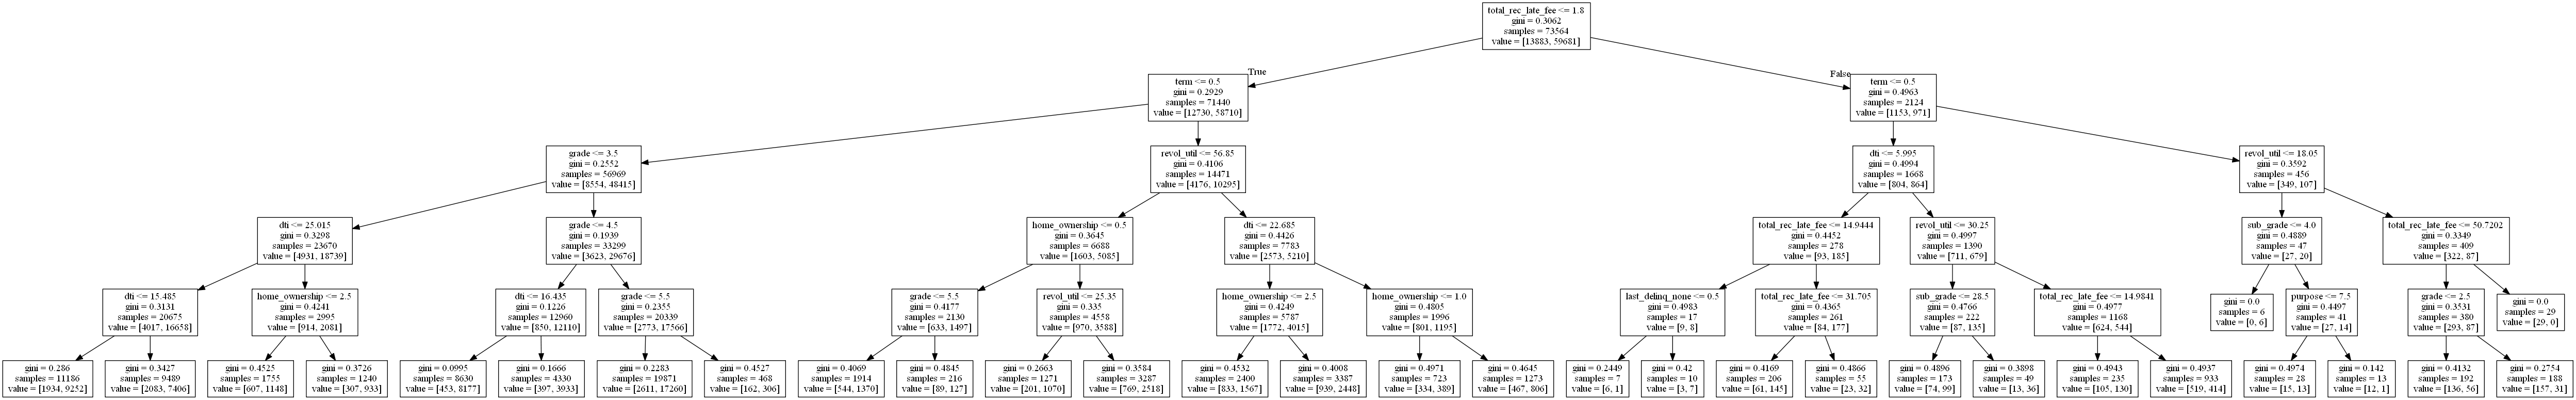

In [17]:
import pydotplus
graph = pydotplus.graph_from_dot_data(out.getvalue())
Image(graph.create_png())